In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import f90_src
import scipy
import math
from scipy.optimize import minimize, curve_fit


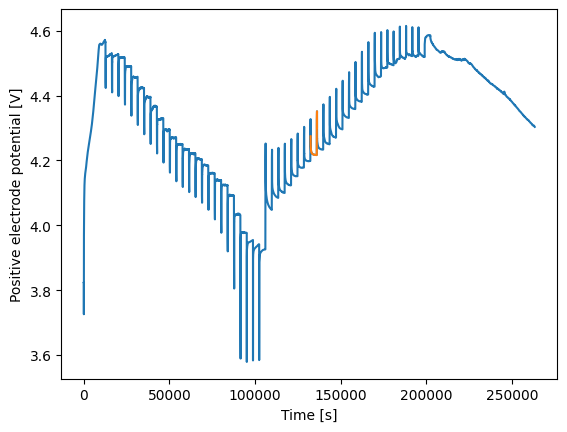

In [2]:
#Read in the experiental data 
df = pd.read_csv("data3.csv")
t = df['Time [s]']
t = t.to_numpy(t)
pot = df['Positive electrode potential [V]']
pot = pot.to_numpy(pot)
curr = df['Current [A]']
curr = curr.to_numpy(curr)
ind = df['Index']
ind = ind.to_numpy(ind)


#Separate the data in 2 sections and find the maxima 
sec1 = curr[:6770]
sec2 = curr[6769:]
potmin = []
timemin = []
indices = [] 

for i in range(1, len(sec1)-1):
    #if (curr[i] == 0) and ((curr[i] - curr[i-1]) < 0):
    if (curr[i] == 0) and ((curr[i+1] - curr[i]) > 0):
        potmin.append(pot[i-1])
        timemin.append(t[i-1])
        indices.append(ind[i-1])

for i in range(6769, 6769+len(sec2)-1):
    #if (curr[i] == 0) and ((curr[i+1] - curr[i]) > 0):
    if (curr[i] == 0) and ((curr[i] - curr[i-1]) < 0):
        potmin.append(pot[i+1])
        timemin.append(t[i+1])
        indices.append(ind[i+1])


#Clean up the irrelevant maxima
potmin = np.array(potmin)
timemin = np.array(timemin)
indices = np.array(indices)
indices_to_remove = [0, 1, 53, 54]
potmin = potmin[~np.isin(np.arange(potmin.size), indices_to_remove)]
timemin = timemin[~np.isin(np.arange(timemin.size), indices_to_remove)]
indices = indices[~np.isin(np.arange(indices.size), indices_to_remove)]

#Split the data into chunks 
pot_split = np.split(pot, indices)
t_split = np.split(t, indices)


#Plotting 
plt.plot(t, pot)
#uncomment to zoom in at a particular time section
#plt.xlim(100000,110000)

#Plots the maxima
#plt.plot(timemin, potmin, 'x')

#Plots the chunk 
plt.plot(t_split[33], pot_split[33])
plt.xlabel("Time [s]")
plt.ylabel("Positive electrode potential [V]")
plt.show()

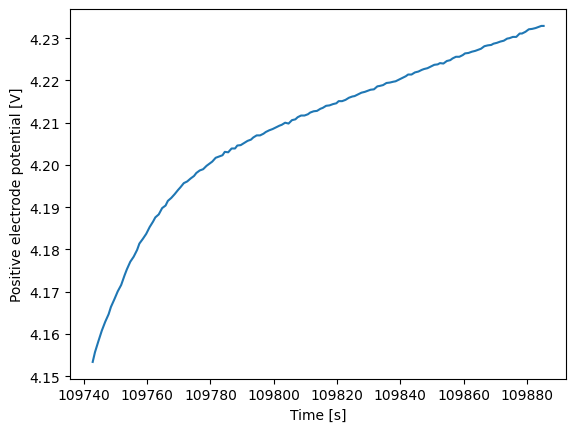

In [3]:
pot_split_new = []
t_split_new = []

pot_split_new2 = []
t_split_new2 = []


#section 1 has 24 peaks
for i in range(1, 23):
    p_mx = np.max(pot_split[i])
    p_mn = np.min(pot_split[i])
    p_mx_ind = np.where((pot_split[i] == p_mx))
    p_mn_ind = np.where((pot_split[i] == p_mn))
    mx_ind = p_mx_ind[0][0]
    mn_ind = p_mn_ind[0][0]
    pot_split_n = np.zeros(mn_ind)
    t_split_n = np.zeros(mn_ind)
    pot_split_n[:mn_ind] = pot_split[i][mx_ind:mn_ind]
    t_split_n[:mn_ind] = t_split[i][mx_ind:mn_ind]
    indices_to_remove = [0, 1, 2,3, 4, 5, 6, 7, 8, 9, 10]
    pot_split_n =  pot_split_n[~np.isin(np.arange( pot_split_n.size), indices_to_remove)]
    t_split_n = t_split_n[~np.isin(np.arange(t_split_n.size), indices_to_remove)]
    pot_split_new.append(pot_split_n)
    t_split_new.append(t_split_n)
    
    
#section 2 has 28 peaks
for i in range(25,50):
    p_mx = np.max(pot_split[i])
    p_mn = np.min(pot_split[i])
    p_mx_ind = np.where((pot_split[i] == p_mx))
    p_mn_ind = np.where((pot_split[i] == p_mn))
    mx_ind = p_mx_ind[0][0]
    mn_ind = p_mn_ind[0][0]
    pot_split_n = np.zeros(mx_ind-mn_ind)
    t_split_n = np.zeros(mx_ind-mn_ind)

    pot_split_n[:] = pot_split[i][mn_ind:mx_ind]
    t_split_n[:] = t_split[i][mn_ind:mx_ind]
    indices_to_remove = [0, 1, 2,3, 4, 5, 6, 7, 8, 9, 10]
    pot_split_n =  pot_split_n[~np.isin(np.arange( pot_split_n.size), indices_to_remove)]
    t_split_n = t_split_n[~np.isin(np.arange(t_split_n.size), indices_to_remove)]
    pot_split_new2.append(pot_split_n)
    t_split_new2.append(t_split_n)
    
#plt.plot(t_split_new[1], pot_split_new[1])
plt.plot(t_split_new2[1], pot_split_new2[1])
plt.xlabel('Time [s]')
plt.ylabel('Positive electrode potential [V]')
plt.show()


In [4]:
#functions 
def analyse_chunk(ch, t_split_new, pot_split_new):
    pot_chunk = pot_split_new[ch]
    t_chunk = t_split_new[ch]
    t_real_chunk = t_split_new[ch] - t_split_new[ch][0]
    totaltime = len(t_real_chunk)
    #totaltime = int(t_split_new[ch][-1]-t_split_new[ch][0])
    return totaltime, pot_chunk, t_real_chunk, t_chunk

In [5]:
def voltages_data(diff, totaltime):
    volt = np.array((totaltime), order="F")
    volt = f90_src.datafitpde.crank_nicholson(n=n, totaltime=totaltime, d=diff, r=R, volper=volPer,
                                              iapp=iapp, f=F, l=L, rg=Rg, t=T, k=K, maxcon=maxCon,
                                              c0=c0, dt=dt)
    #simulation time, dt = 1
    time_plot = np.zeros(totaltime)
    for i in range(totaltime):
        time_plot[i]=i 
        
    return volt, time_plot

#volt_simul, time_simul = voltages_data(D, totaltime)

In [6]:
def interpolate_point(volt_simul, time_simul, t):
        time = math.floor(t)
        v1 = volt_simul[time]
        t1 = time_simul[time]
        t2 = time_simul[time+1]
        v2 = volt_simul[time+1]
        time_array = [t1, t2]
        volt_array = [v1, v2]
        v_int = np.interp(t, time_array, volt_array)
        t_int = t
        return v_int, t_int
    

In [7]:
#make an array of interpolated points for the optimiser
def create_int_array(volt_simul, time_simul, t_chunk, pot_chunk):
    v_inter = np.zeros(len(t_real_chunk))
    t_inter = np.zeros(len(t_real_chunk))
    for i in range(len(t_real_chunk)-1):
        vi, ti = interpolate_point(volt_simul, time_simul, t_real_chunk[i])
        t_inter[i] = ti
        v_inter[i] = vi
    v_inter[-1] = v_inter[-1-1]
    t_inter[-1] = t_inter[-1-1]
    return t_inter, v_inter

In [8]:
#chunk of experimental data to analyse (min = 1, max = 24)
ch = 1
n = 20
D = 1.48 * 10**(-15)
R = 5.22 * 10**(-6)
volPer = 66.5
iapp = -48.65656
F = 96485.3321
L = 75.6 * 10**(-6)
Rg = 8.31446261815324
T = 294.15
K = 3.42
maxCon = 51765.0000001
c0 = np.ones(n, order="F")
c0 = c0*40000
c0 = np.asfortranarray(c0)
#timeArr = t_split[1] 
#timeArr = np.asfortranarray(timeArr)
#maxcon=np.array([maxCon], dtype=float)
dt = 1



In [9]:
totaltime, pot_chunk, t_real_chunk, t_chunk = analyse_chunk(ch, t_split_new, pot_split_new)
volt_simul, time_simul = voltages_data(D, totaltime)
t_int, v_int = create_int_array(volt_simul, time_simul, t_chunk, pot_chunk)
#introduce I*R shift
difference = np.average(volt_simul-pot_chunk)

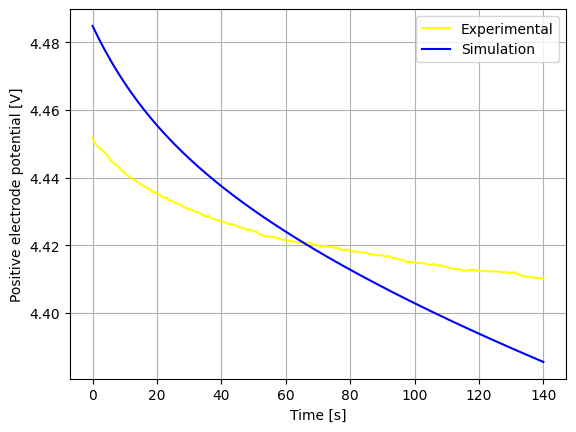

In [10]:
#plot experimental data vs interpolation from the simulation
plt.plot(t_real_chunk, pot_chunk, color="yellow", label='Experimental')
plt.plot(time_simul, volt_simul-difference, color="blue", label='Simulation')
#plt.plot(t_int, v_int-difference, 'x', label='Interpolated Sim.')
plt.xlabel("Time [s]")
plt.ylabel("Positive electrode potential [V]")
plt.legend(loc='best')
plt.grid()
plt.show()

In [11]:
def voltages_data2(timearray, diff):
    totaltime = len(timearray)
    volt = np.array((totaltime), order="F")
    volt = f90_src.datafitpde.crank_nicholson(n=n, totaltime=totaltime, d=diff, r=R, volper=volPer,
                                              iapp=iapp, f=F, l=L, rg=Rg, t=T, k=K, maxcon=maxCon,
                                              c0=c0, dt=dt)
    difference = np.average(volt-pot_chunk)
    volt = volt-difference
        
    return volt

In [12]:
# Now run a loop over all the chunks to find the optimal diffusion coefficient for each chunk:
pot_chunk_dict = {}
t_real_chunk_dict = {}
fitted_V_dict = {}
D_fit_array = []
D_err_array = []
chunk_array = []
D_guess = 1.48 * 10**(-15)
for ch in range(len(t_split_new)):
    key="ch="+str(ch)
    #Extract corresponding chunk:
    totaltime, pot_chunk, t_real_chunk, t_chunk = analyse_chunk(ch, t_split_new, pot_split_new)
    pot_chunk_dict.update({key:pot_chunk})
    t_real_chunk_dict.update({key:t_real_chunk})
    #Fit the chunk:
    fitted_curve = curve_fit(f=voltages_data2, xdata=t_real_chunk, ydata=pot_chunk, p0=np.array([D_guess]));
    D_fit = fitted_curve[0][0]
    D_err = fitted_curve[1][0]
    D_fit_array.append(D_fit)
    D_err_array.append(D_err)
    chunk_array.append(ch)
    volt_fit = voltages_data2(t_real_chunk, D_fit);
    fitted_V_dict.update({key:volt_fit})

D_err_array = np.reshape(D_err_array, (len(D_err_array), ))

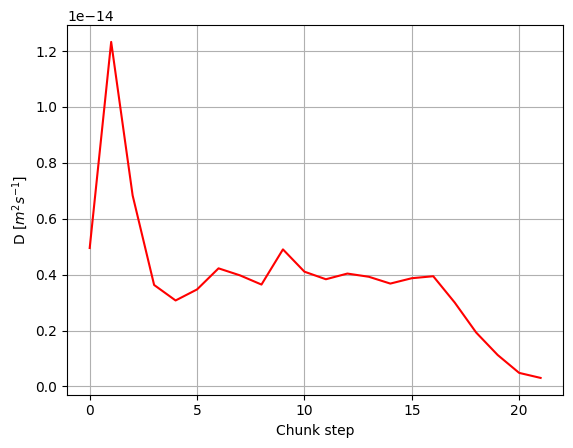

In [13]:
plt.errorbar(x=np.array(chunk_array), y=np.array(D_fit_array), 
             yerr=np.array(D_err_array), color='red', label='Diffusion coefficient')
plt.xlabel('Chunk step')
plt.ylabel(r'D [$m^2 s^{-1}$]')
plt.grid()
plt.show()

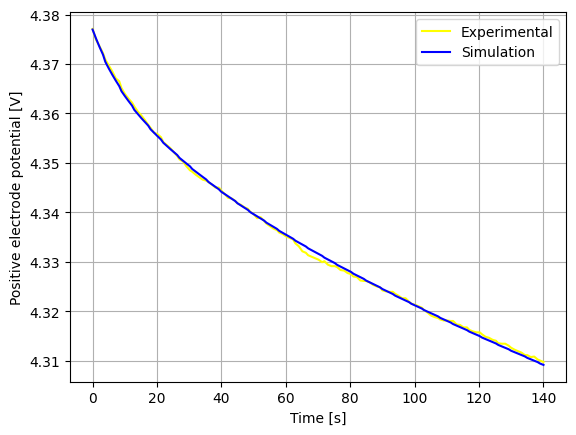

In [14]:
#ch = 1 to 21
ch=5
key="ch="+str(ch)
#plot experimental data vs interpolation from the simulation
plt.plot(t_real_chunk_dict[key], pot_chunk_dict[key], color="yellow", label='Experimental')
plt.plot(t_real_chunk_dict[key], fitted_V_dict[key], color="blue", label='Simulation')
#plt.plot(t_int, v_int, 'x')
plt.xlabel("Time [s]")
plt.ylabel("Positive electrode potential [V]")
plt.legend(loc='best')
plt.grid()
plt.show()

In [15]:
# Now run a loop over the second group of chunks to find the optimal diffusion coefficient for each chunk:
iapp = -iapp
pot_chunk_dict2 = {}
t_real_chunk_dict2 = {}
fitted_V_dict2 = {}
D_fit_array2 = []
D_err_array2 = []
chunk_array2 = []
D_guess = 1.48 * 10**(-15)
for ch in range(len(t_split_new2)):
    key="ch="+str(ch+len(t_split_new))
    #Extract corresponding chunk:
    totaltime, pot_chunk, t_real_chunk, t_chunk = analyse_chunk(ch, t_split_new2, pot_split_new2)
    pot_chunk_dict2.update({key:pot_chunk})
    t_real_chunk_dict2.update({key:t_real_chunk})
    #Fit the chunk:
    fitted_curve = curve_fit(f=voltages_data2, xdata=t_real_chunk, ydata=pot_chunk, p0=np.array([D_guess]));
    D_fit = fitted_curve[0][0]
    D_err = fitted_curve[1][0]
    D_fit_array2.append(D_fit)
    D_err_array2.append(D_err)
    chunk_array2.append(ch+len(t_split_new))
    volt_fit = voltages_data2(t_real_chunk, D_fit);
    fitted_V_dict2.update({key:volt_fit})

D_err_array2 = np.reshape(D_err_array2, (len(D_err_array2), ))

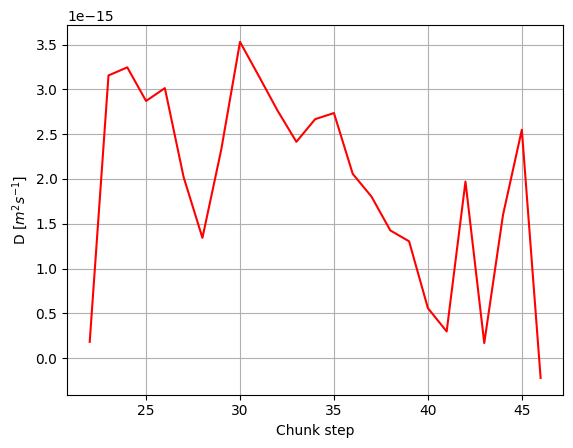

In [16]:
plt.errorbar(x=np.array(chunk_array2), y=np.array(D_fit_array2), 
             yerr=np.array(D_err_array2), color='red', label='Diffusion coefficient')
plt.xlabel('Chunk step')
plt.ylabel(r'D [$m^2 s^{-1}$]')
plt.grid()
plt.show()

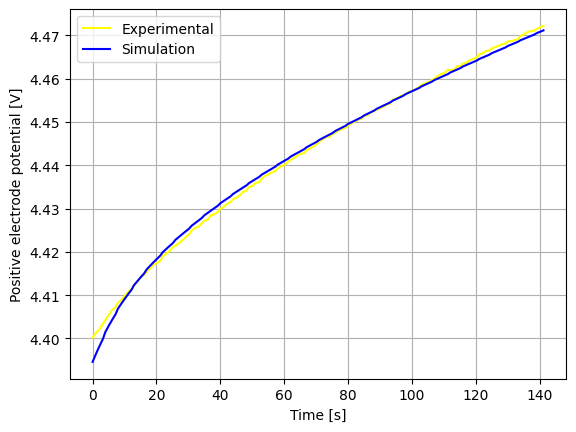

In [17]:
#ch = 22 to 46
ch=35
key="ch="+str(ch)
#plot experimental data vs interpolation from the simulation
plt.plot(t_real_chunk_dict2[key], pot_chunk_dict2[key], color="yellow", label='Experimental')
plt.plot(t_real_chunk_dict2[key], fitted_V_dict2[key], color="blue", label='Simulation')
#plt.plot(t_int, v_int, 'x')
plt.xlabel("Time [s]")
plt.ylabel("Positive electrode potential [V]")
plt.legend(loc='best')
plt.grid()
plt.show()

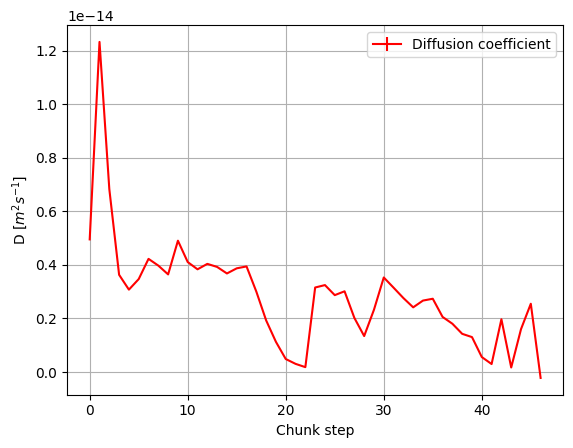

In [18]:
#Plotting both fits:
chunks = np.concatenate((chunk_array, chunk_array2))
D_fits = np.concatenate((D_fit_array, D_fit_array2))
D_errs = np.concatenate((D_err_array, D_err_array2))
plt.errorbar(chunks, D_fits, D_errs, color='red', label='Diffusion coefficient')
plt.xlabel('Chunk step')
plt.ylabel(r'D [$m^2 s^{-1}$]')
plt.grid()
plt.legend()
plt.savefig('fitted_diff_coeffs.png', dpi=300)
plt.show()